In [1]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, label
from IPython.display import FileLink

In [ ]:
!pip install ultralytics


image 1/1 /content/07240_MVR_prev.png: 416x512 2 occupieds, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 512)
Prediction 2:
Class ID: 1.0
Coordinates (xywh): tensor([610.8882, 162.2169, 272.5621, 267.3400], device='cuda:0')
Confidence: 0.01027301698923111



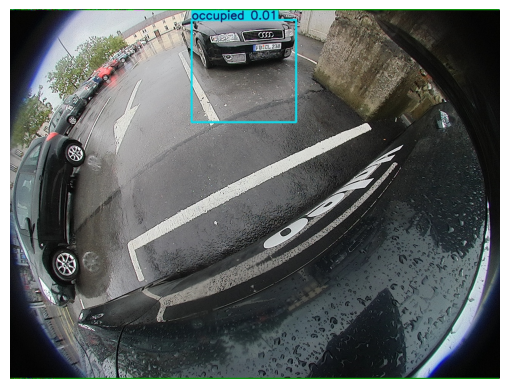

In [98]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# Путь к модели, которую вы хотите загрузить
model_path = 'best.pt'  # Путь к лучшей модели, полученной в процессе тренировки

# Загрузка обученной модели
model = YOLO(model_path)

# Путь к изображению для предсказания
img_path = '07240_MVR_prev.png'  # Замените на путь к вашему изображению

# Выполнение предсказания
confidence_threshold = 0.01  # Порог вероятности
results = model.predict(img_path, conf=confidence_threshold)

# Получение детекций в виде pandas DataFrame
predictions = results[0].boxes.xywh  # Координаты предсказанных объектов в формате [x_center, y_center, width, height]
confidence = results[0].boxes.conf  # Уверенность (confidence)
class_ids = results[0].boxes.cls  # Идентификаторы классов

# Выводим информацию о предсказанных объектах
for i in range(len(predictions)):
    print(f"Prediction {i+1}:")
    print(f"Class ID: {class_ids[i]}")
    print(f"Coordinates (xywh): {predictions[i]}")
    print(f"Confidence: {confidence[i]}")
    print("")

# Отображение изображений с наложением предсказанных объектов
results[0].plot()  # Показывает изображение с детекциями

# Если нужно сохранить изображение с результатами:
output_path = 'bbox.jpg'
results[0].save(filename=output_path)

# Для отображения изображения с помощью Matplotlib:
img = plt.imread(output_path)
plt.imshow(img)
plt.axis('off')  # Отключаем оси
plt.show()

In [95]:
# --- Настройки ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "deeplabv3p_epoch20.pth"
IMAGE_PATH = "07240_MVR_prev.png"

# --- Инициализация модели ---
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=False, num_classes=2)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# --- Удаление несоответствующих ключей ---
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(filtered_state_dict, strict=False)

model.to(DEVICE)
model.eval()

# --- Преобразование тестового изображения ---
image = Image.open(IMAGE_PATH).convert("RGB")
original_size = image.size  # Сохраняем исходный размер

transform = transforms.Compose([
    transforms.Resize((2048, 2048)),  # Приведение изображения к фиксированному размеру
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

input_tensor = transform(image).unsqueeze(0).to(DEVICE)

# --- Прогнозирование ---
with torch.no_grad():
    with torch.amp.autocast("cuda"):
        output = model(input_tensor)["out"]

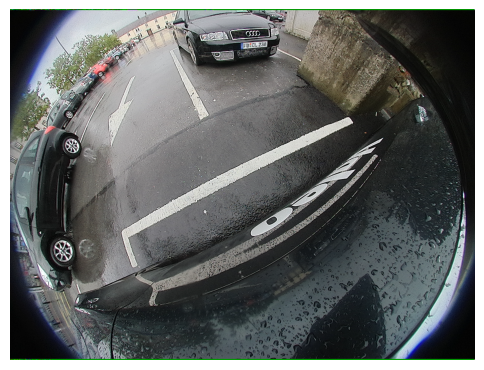

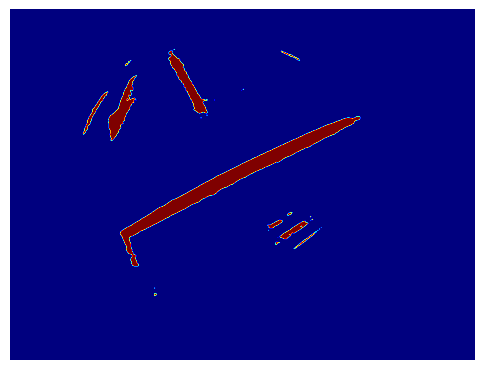

In [96]:
# Применяем сигмоиду, чтобы получить вероятности
probabilities = torch.sigmoid(output)

# Установите порог
threshold = 0.4
pred_mask = probabilities[0, 1, :, :].cpu().numpy() > threshold

# --- Масштабирование маски до исходного размера ---
pred_mask_resized = Image.fromarray(pred_mask.astype('uint8'))
pred_mask_resized = pred_mask_resized.resize(original_size, Image.NEAREST)
pred_mask_resized = np.array(pred_mask_resized)

# --- Отображение оригинала ---
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

# --- Отображение маски ---
plt.figure(figsize=(6, 6))
plt.imshow(pred_mask_resized, cmap="jet")
plt.axis('off')
plt.show()

In [97]:
# Сохранение оригинала изображения в формате JPG
image.save('original.jpg', 'JPEG')

# Сохранение маски в формате JPG
pred_mask_resized_image = Image.fromarray(pred_mask_resized.astype('uint8'))
pred_mask_resized_image.save('pred_mask_resized.jpg', 'JPEG')

FileLink('original.jpg'), FileLink('pred_mask_resized.jpg')

(/content/original.jpg, /content/pred_mask_resized.jpg)

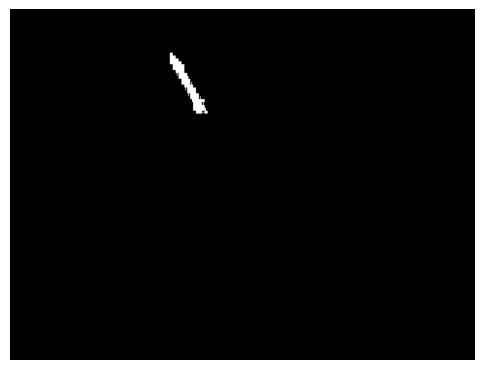

In [99]:
segmentation_image = Image.open('pred_mask_resized.jpg')
bbox_image = Image.open('bbox.jpg')

# Приводим изображения к одинаковому размеру (по размеру изображения с баундинг боксом)
segmentation_image = segmentation_image.resize(bbox_image.size, Image.Resampling.LANCZOS)

segmentation = np.array(segmentation_image)
bbox = np.array(bbox_image)

red_mask = (segmentation == 1)

# Определяем маски для двух классов цветов
blueish_mask_1 = np.all((bbox >= [20, 210, 220]) & (bbox <= [22, 214, 240]), axis=-1)  # occupied
blueish_mask_2 = np.all((bbox >= [2, 40, 250]) & (bbox <= [4, 46, 255]), axis=-1)  # empty

# Объединяем обе маски в одну
combined_mask = blueish_mask_1 | blueish_mask_2

# Найдем координаты прямоугольника, объединяя области обоих классов
rows, cols = combined_mask.shape

# Инициализация значений для минимальных и максимальных координат
y_min, y_max = None, None
x_min, x_max = None, None

# Поиск пикселей и вычисление границ
for i in range(rows):
    for j in range(cols):
        if combined_mask[i, j]:
            if y_min is None or i < y_min:
                y_min = i
            if y_max is None or i > y_max:
                y_max = i
            if x_min is None or j < x_min:
                x_min = j
            if x_max is None or j > x_max:
                x_max = j

# Если не найдено пикселей нужного цвета, не создаем маску баундинг бокса
if None in [y_min, y_max, x_min, x_max]:
    print("Пиксели заданных цветов не найдены в маске!")
else:
    # Маска для области внутри баундинг бокса
    bbox_mask = np.zeros_like(combined_mask, dtype=bool)
    bbox_mask[y_min:y_max+1, x_min:x_max+1] = True  # Маска для области внутри баундинг бокса

    # Расширяем маску баундинг бокса для захвата соприкасающихся объектов
    expanded_bbox_mask = binary_dilation(bbox_mask, structure=np.ones((10, 10)))  # Расширяем маску для захвата соприкасающихся объектов

# Теперь найдем все объекты (сегменты), которые соприкасаются с баундинг боксом
labeled_segments, num_segments = label(red_mask)

# Для каждого сегмента проверяем, пересекается ли он с расширенной маской баундинг бокса
result_mask = np.zeros_like(red_mask, dtype=bool)

for segment_id in range(1, num_segments + 1):
    # Находим координаты всех пикселей этого сегмента
    segment_mask = (labeled_segments == segment_id)

    # Если хотя бы один пиксель этого сегмента пересекается с расширенной маской баундинг бокса
    if np.any(segment_mask & expanded_bbox_mask):
        result_mask |= segment_mask  # Добавляем весь сегмент в результат

# Преобразуем результат в изображение
result = np.zeros_like(red_mask, dtype=np.uint8)
result[result_mask] = 255  # Сохраняем только те пиксели, которые относятся к пересекающимся сегментам
result_image = Image.fromarray(result)

# Сохранение и отображение результата
result_image.save('result.png')
plt.figure(figsize=(6, 6))
plt.imshow(result_image, cmap='gray')
plt.axis('off')
plt.show()


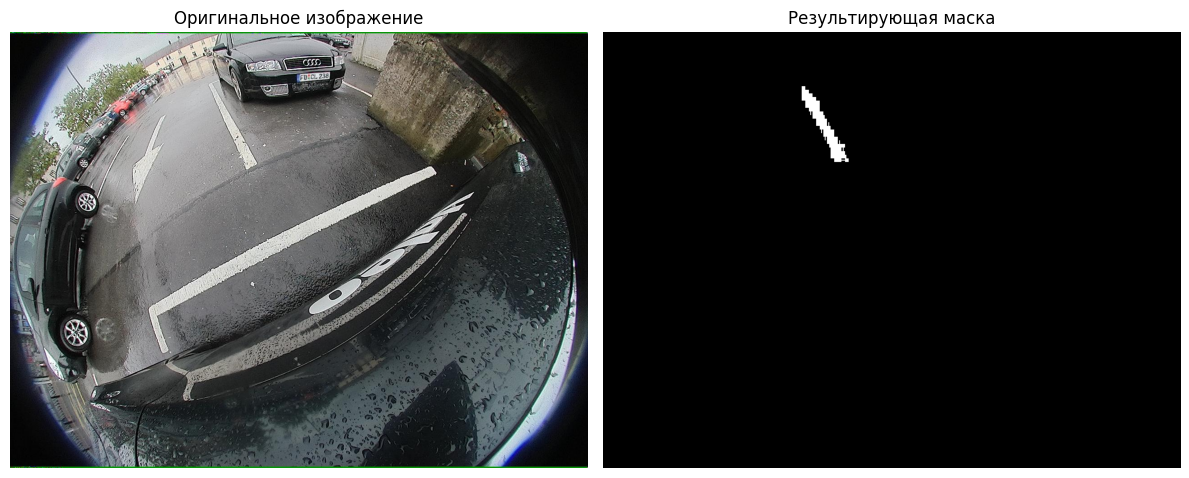

In [100]:
# Открытие оригинального изображения
original_image = Image.open('original.jpg')

# Создание субплотов для отображения оригинала и маски
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Отображение оригинального изображения
axs[0].imshow(original_image)
axs[0].set_title("Оригинальное изображение")
axs[0].axis('off')

# Отображение результирующей маски
axs[1].imshow(result_image, cmap='gray')
axs[1].set_title("Результирующая маска")
axs[1].axis('off')

# Отображение всех графиков
plt.tight_layout()
plt.show()
